In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


We define the dataset as an xarray aswell, so it fits PyMC.

In [5]:
df_xa = df.to_xarray()

In [6]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Hypothesis 2 (w Normal Dist.)

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

This time we attempt to model Hypothesis 2 in a normal distribution manner by also standardizing number of bugs (B). We believe that this implementation at least gives us a better interpretation.

The model is defined as follows:

$$B_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_{\mathrm{L}[i]} A_i$$

As for the prior for $\alpha$, $\beta_{\mathrm{L}[i]}$ and $\sigma$, we'll set plausible values in the next section.

In [7]:
def standardize_column(variable):
    # Standardize the column
    standardized_column = (variable - variable.mean()) / variable.std()
    
    return standardized_column

In [8]:
df['age_std'] = standardize_column(df['age'])

In [9]:
df['bug_std'] = standardize_column(df['bugs'])

In [10]:
language_idx, languages = pd.factorize(df.language)

### Determine priors 

* Determine prior $\alpha$


In [11]:
with pm.Model() as m_h2:
    alpha = pm.Normal("alpha", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.2, shape=languages.size)
    sigma = pm.Exponential("sigma", 1.0)

    #We add language_ids and age_std as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', language_idx, mutable=True)
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                alpha + bA[language_ids] * age_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bug_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m_h2_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    m_h2_idata.extend(pm.sample(random_seed = rng))

Sampling: [B, alpha, bA, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


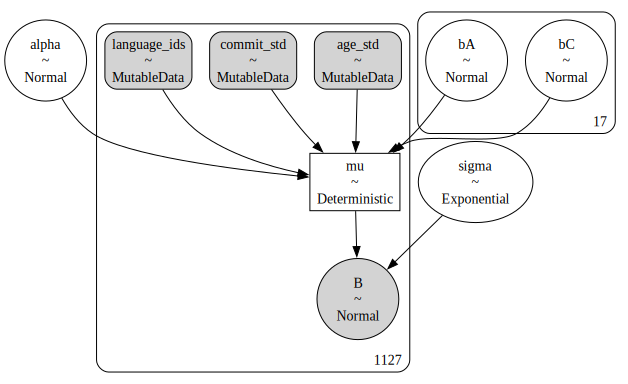

In [54]:
pm.model_graph.model_to_graphviz(m_h2)

(-2.0, 2.0)

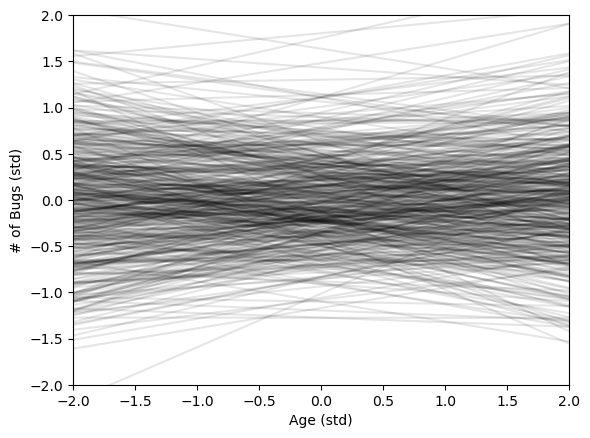

In [40]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = m_h2_idata.prior.alpha[0]
bA_ = m_h2_idata.prior.bA[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Age (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

In [33]:
#specifying names of the variables
var_names_langauge = list(m_h2_idata.posterior.data_vars.keys())[:-1]
pm.summary(m_h2_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.02,0.03,-0.08,0.03,0.0,0.0,9361.35,3481.55,1.0
bA[0],0.04,0.15,-0.22,0.35,0.0,0.0,8636.37,2588.49,1.0
bA[1],0.03,0.05,-0.06,0.13,0.0,0.0,10069.09,2605.92,1.0
bA[2],0.02,0.14,-0.25,0.28,0.0,0.0,10505.73,3010.70,1.0
bA[3],0.06,0.12,-0.17,0.29,0.0,0.0,10512.86,2724.50,1.0
bA[4],0.17,0.12,-0.04,0.39,0.0,0.0,9145.93,2998.30,1.0
bA[5],0.45,0.13,0.20,0.69,0.0,0.0,8784.21,3038.44,1.0
bA[6],-0.01,0.11,-0.21,0.18,0.0,0.0,7915.02,2607.66,1.0
bA[7],0.49,0.07,0.35,0.63,0.0,0.0,7634.27,3144.27,1.0
bA[8],0.16,0.09,-0.01,0.32,0.0,0.0,8717.39,2980.08,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

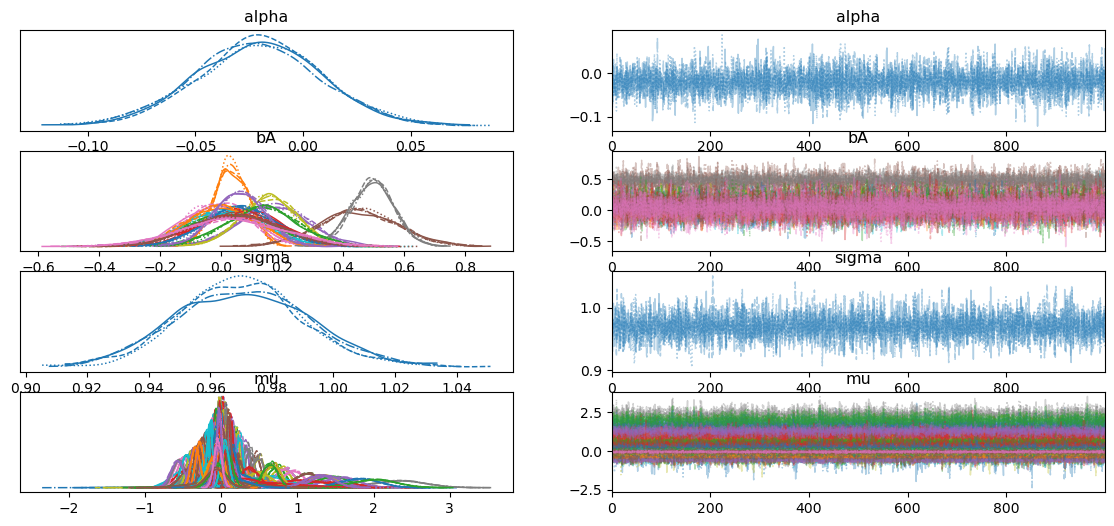

In [35]:
az.plot_trace(m_h2_idata, figsize=(14, 3*2))

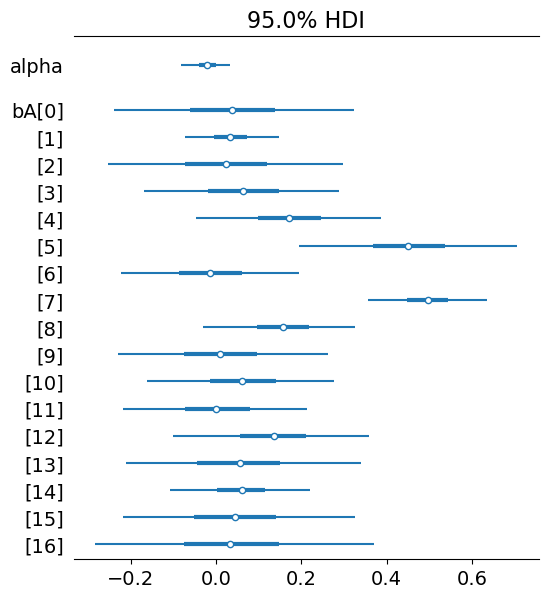

In [37]:
pm.plot_forest(m_h2_idata, var_names=['alpha','bA'], hdi_prob=.95, combined=True);

In [12]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with m_h2:
    pm.set_data({"age_std": x_seq, "language_ids": np.repeat(6, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h2_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


In [75]:
df['language'].value_counts()

language
Javascript      202
Python          102
C++              86
C                82
Java             74
Ruby             67
Typescript       58
Php              57
Objective-C      56
Coffeescript     52
C#               51
Clojure          50
Scala            46
Erlang           42
Haskell          39
Go               38
Perl             25
Name: count, dtype: int64

In [73]:
languages

Index(['Clojure', 'Javascript', 'Objective-C', 'Java', 'Php', 'C#', 'Perl',
       'C', 'C++', 'Erlang', 'Haskell', 'Typescript', 'Ruby', 'Coffeescript',
       'Python', 'Go', 'Scala'],
      dtype='object')

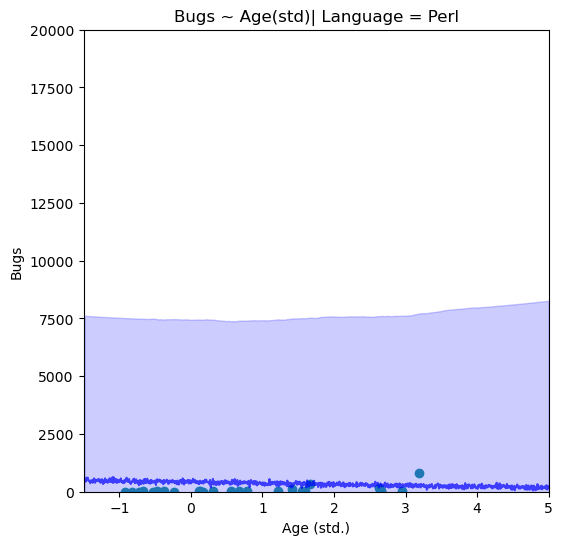

In [84]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Age(std)| Language = Perl");

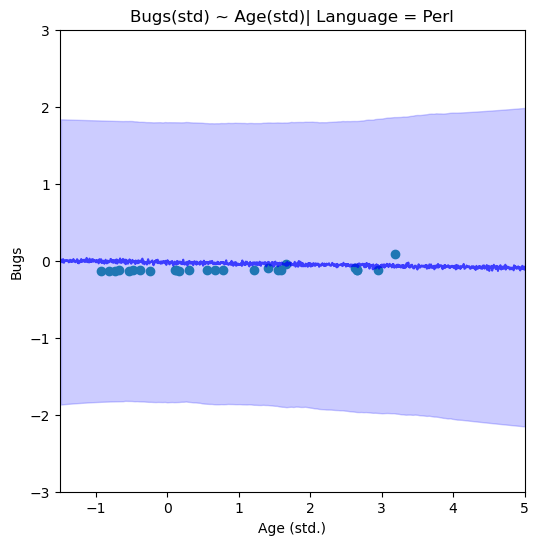

In [14]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean, color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bug_std)


plt.xlim(-1.5,5.0)
#plt.ylim(0,20000)
plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs(std) ~ Age(std)| Language = Perl");

## Hypothesis 3

In [16]:
df['commit_std'] = standardize_column(df['commits'])

In [38]:
with pm.Model() as m_h3:
    alpha = pm.Normal("alpha", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.2, shape=languages.size)
    bC = pm.Normal("bC", 1, 0.2, shape=languages.size)
    sigma = pm.Exponential("sigma", 1)

    #We add language_ids and age_std, com_std as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', language_idx, mutable=True)
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    commit_std = pm.Data("commit_std", df.commit_std, mutable=True)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                alpha + bA[language_ids] * age_std + bC[language_ids] * commit_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bug_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m_h3_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    m_h3_idata.extend(pm.sample(random_seed = rng))

Sampling: [B, alpha, bA, bC, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, bC, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


(-2.0, 2.0)

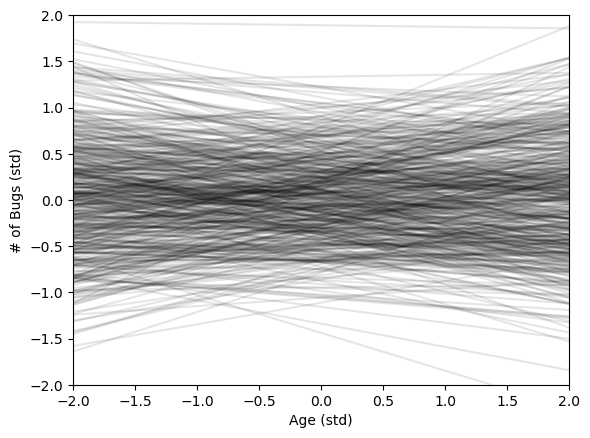

In [40]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = m_h3_idata.prior.alpha[0]
bA_ = m_h3_idata.prior.bA[0][:,0]
bC_ = m_h3_idata.prior.bC[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Age (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

(-2.0, 2.0)

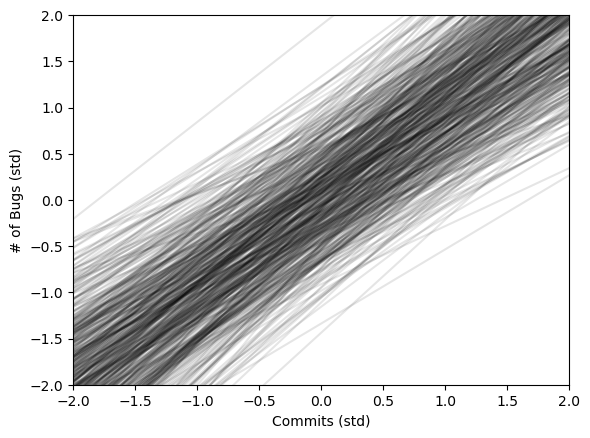

In [39]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = m_h3_idata.prior.alpha[0]
bC_ = m_h3_idata.prior.bC[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bC_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Commits (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

In [34]:
#specifying names of the variables
var_names_langauge = list(m_h3_idata.posterior.data_vars.keys())[:-1]
pm.summary(m_h3_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.01,0.00,-0.01,-0.00,0.0,0.0,3802.92,3137.98,1.0
bA[0],-0.00,0.03,-0.04,0.05,0.0,0.0,4506.80,3244.48,1.0
bA[1],0.01,0.01,-0.00,0.02,0.0,0.0,6302.27,3463.90,1.0
bA[2],0.00,0.02,-0.03,0.04,0.0,0.0,5133.61,3547.88,1.0
bA[3],-0.02,0.01,-0.04,0.00,0.0,0.0,5102.36,3194.74,1.0
bA[4],0.01,0.01,-0.02,0.03,0.0,0.0,4731.83,3252.58,1.0
bA[5],0.01,0.02,-0.03,0.04,0.0,0.0,3368.56,2914.31,1.0
bA[6],0.01,0.01,-0.02,0.03,0.0,0.0,5456.00,3186.41,1.0
bA[7],0.04,0.01,0.03,0.06,0.0,0.0,5248.30,3221.75,1.0
bA[8],0.01,0.01,-0.01,0.03,0.0,0.0,5411.96,3378.16,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'bC'}>, <Axes: title={'center': 'bC'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

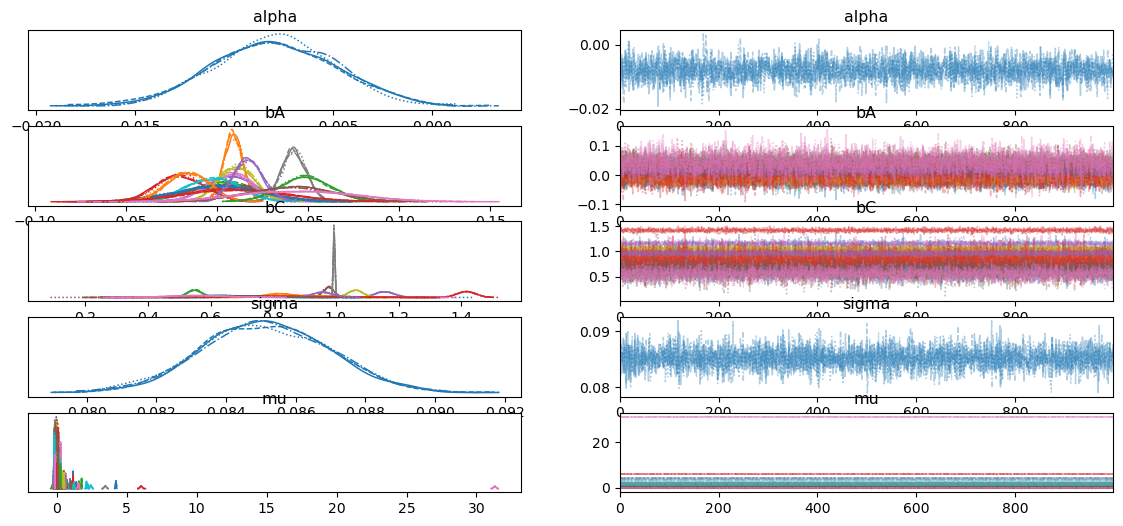

In [32]:
az.plot_trace(m_h3_idata, figsize=(14, 3*2))

In [ ]:
languages

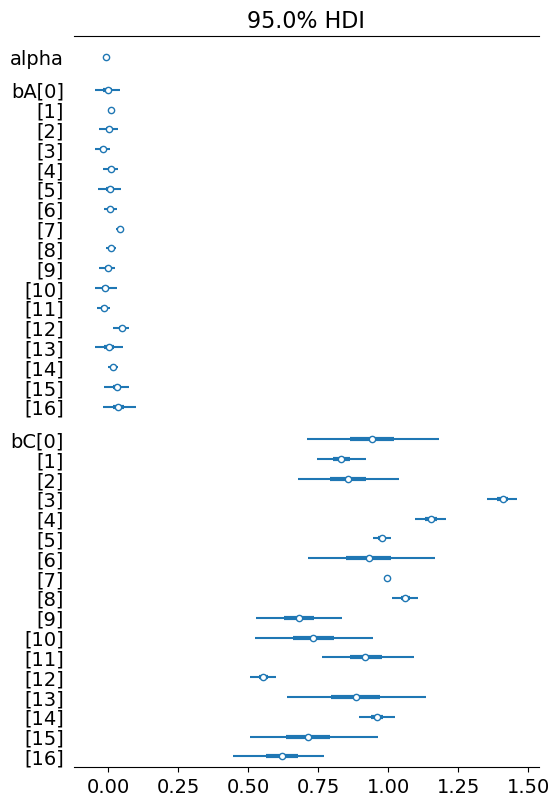

In [41]:
pm.plot_forest(m_h3_idata, var_names=['alpha','bA', 'bC'], hdi_prob=.95, combined=True);

In [42]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with m_h3:
    pm.set_data({"age_std": x_seq, "commit_std": np.repeat(0, n_points), "language_ids": np.repeat(6, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


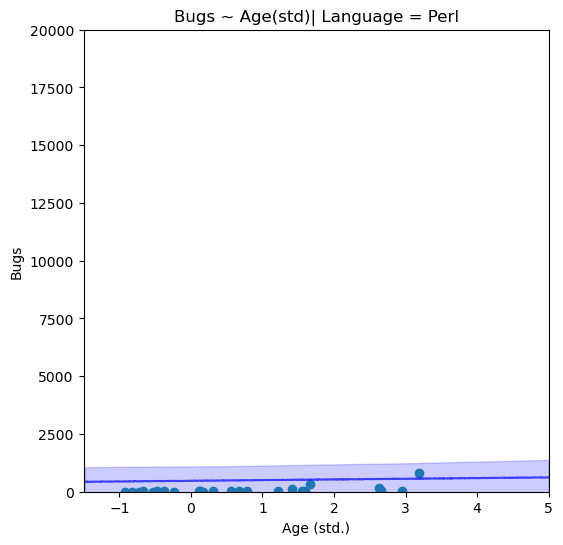

In [43]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Age(std)| Language = Perl");

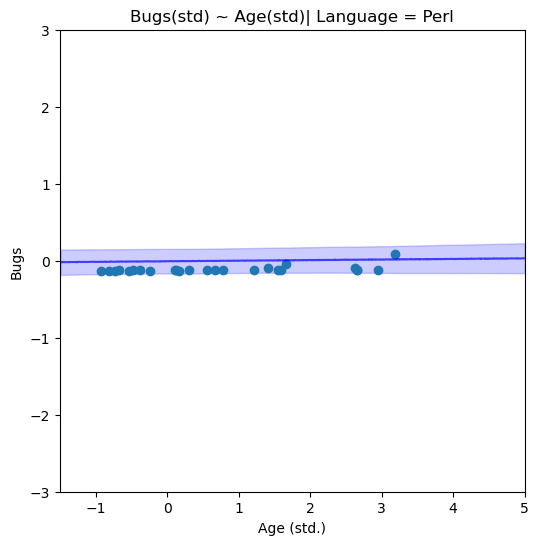

In [44]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean, color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bug_std)


plt.xlim(-1.5,5.0)
#plt.ylim(0,20000)
plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs(std) ~ Age(std)| Language = Perl");

In [45]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with m_h3:
    pm.set_data({"age_std": np.repeat(0, n_points), "commit_std": x_seq, "language_ids": np.repeat(2, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


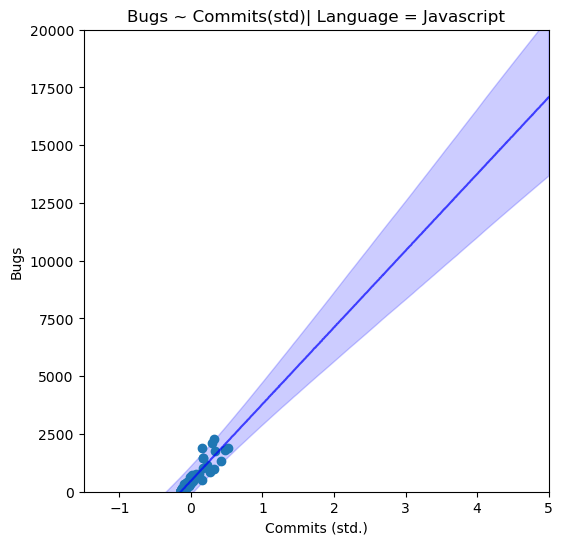

In [48]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Javascript'].commit_std, df[df['language']=='Javascript'].bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Commits (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Commits(std)| Language = Javascript");

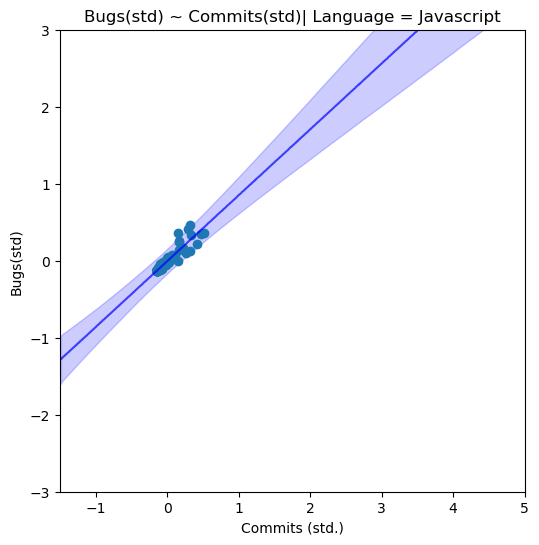

In [53]:
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B, color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean, color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Javascript'].commit_std, df[df['language']=='Javascript'].bug_std)


plt.xlim(-1.5,5.0)
#plt.ylim(0,20000)
plt.ylim(-3.0,3.0)
plt.xlabel('Commits (std.)')
plt.ylabel('Bugs(std)')
plt.title("Bugs(std) ~ Commits(std)| Language = Javascript");